In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx

from src.depth import DepthPoset, get_ordered_border_matrix_from_matrix_of_heights
from src import poset_scores

from matplotlib import pyplot as plt

import itertools
from tqdm.notebook import tqdm


# Test geting border matrix method

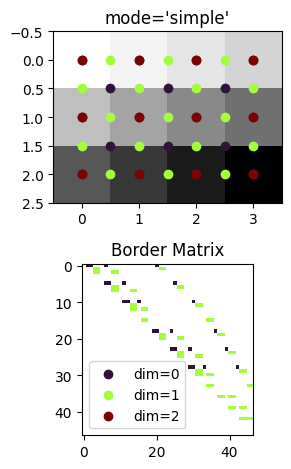

In [3]:
shape = (3, 4)
heights = np.linspace(0, 1, np.prod(shape)).reshape(shape)


modes = ['simple']

fig, axs = plt.subplots(2, len(modes), squeeze=False)

for i, mode in enumerate(modes):
    axs[0, i].set_title(f'mode={mode.__repr__()}')
    axs[0, i].imshow(heights, cmap='Greys')

    cmap = plt.get_cmap('turbo')
    
    try:
        sources, matrix, dims, filtration = get_ordered_border_matrix_from_matrix_of_heights(heights, mode=mode)
        
        matrix = matrix.astype(float)
        matrix[matrix == 0] = np.nan
        matrix *= dims.reshape(-1, 1)

        for dim in np.unique(dims):
            y, x = np.array(list(sources[dims == dim])).mean(axis=1).transpose()
            axs[0, i].scatter(x, y, label=f'dim={dim}', color=cmap(dim/matrix.ndim))
        #axs[0, i].legend()
        handles, labels = axs[0, i].get_legend_handles_labels()
        
        axs[1, i].set_title(f'Border Matrix')
        axs[1, i].imshow(matrix, vmin=0, vmax=heights.ndim, cmap=cmap)
        axs[1, i].legend(handles, labels, loc='lower left')
    except Exception as err:
        axs[1, i].set_title(err)
        axs[1, i].set_xticks([])
        axs[1, i].set_yticks([])

plt.tight_layout()
plt.show()

# 1-dimensional Random Walk

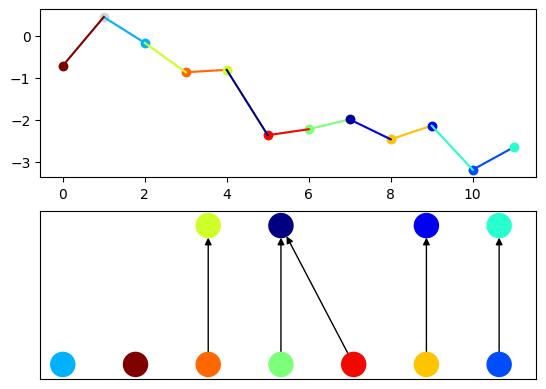

In [4]:
nsteps = 12
steps = np.random.normal(size=nsteps)
walk = np.cumsum(steps)

sources, matrix, dims, filter_values = get_ordered_border_matrix_from_matrix_of_heights(walk)
dp = DepthPoset.from_border_matrix(matrix.astype(int), dims=dims, filter_values=filter_values, sources=sources)

node_colors = np.linspace(0, 1, len(dp.nodes))
node_colors = np.random.choice(node_colors, len(dp.nodes), replace=False)
node_colors = plt.get_cmap('jet')(node_colors)


fig, axs = plt.subplots(2)

axs[0].plot(walk, marker='o', color='lightgrey', linestyle=':', zorder=0)
for inode, node in enumerate(dp.nodes):
    simplex1, simplex0 = node.source
    simplex1 = list(simplex1)
    x0, y0 = simplex0, walk[simplex0]
    x1, y1 = simplex1, walk[simplex1]
    axs[0].scatter(x0, y0, color=node_colors[inode], zorder=1)
    axs[0].plot(x1, y1, color=node_colors[inode], zorder=1)

nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.hasse_layout(), node_color=node_colors, ax=axs[1], with_labels=False)
plt.show()

The questions, which are interesting to answer:
1. Verify the proportion of shallow pair to all pairs increasing the length of the random walk


In [5]:
repeat = 10
ns = np.concatenate([[2, 5], np.arange(10, 100, 10), np.arange(100, 301, 20)])
slopes = [0, 0.05]

scores = [poset_scores.number_of_nodes, 
          poset_scores.number_of_minimal_nodes, 
          poset_scores.number_of_maximal_nodes, 
          poset_scores.height, 
          poset_scores.width, 
]


res = []

for n, slope, _ in tqdm(itertools.product(ns, slopes, range(repeat)), total=len(ns)*len(slopes)*repeat):
    res.append({'n': n, 'walk slope': slope})
    steps = np.random.normal(size=n)
    walk = np.cumsum(steps)
    walk -= steps[0]
    sources, matrix, dims, filter_values = get_ordered_border_matrix_from_matrix_of_heights(walk)
    dp = DepthPoset.from_border_matrix(matrix.astype(int), dims=dims, filter_values=filter_values, sources=sources)
    res[-1].update({'walk': walk, 
                    'dp': dp})
    for score in scores:
        res[-1].update({score.__name__: score(dp)})
    
df = pd.DataFrame(res)
print(f'df.shape = {df.shape}')
df.head()

  0%|          | 0/440 [00:00<?, ?it/s]

df.shape = (440, 9)


,n,walk slope,walk,dp,number_of_nodes,number_of_minimal_nodes,number_of_maximal_nodes,height,width
0,2,0.0,"[0.0, -0.6804930475168609]",<src.depth.DepthPoset object at 0x798a8e320740>,1,1,1,0,1
1,2,0.0,"[0.0, -0.8014152415696908]",<src.depth.DepthPoset object at 0x798a8e6fe000>,1,1,1,0,1
2,2,0.0,"[0.0, -1.3730453103745683]",<src.depth.DepthPoset object at 0x798a8e22c5f0>,1,1,1,0,1
3,2,0.0,"[0.0, -0.0866042933089266]",<src.depth.DepthPoset object at 0x798a8e311d00>,1,1,1,0,1
4,2,0.0,"[0.0, -1.1588711885695047]",<src.depth.DepthPoset object at 0x798a8e1ff0e0>,1,1,1,0,1


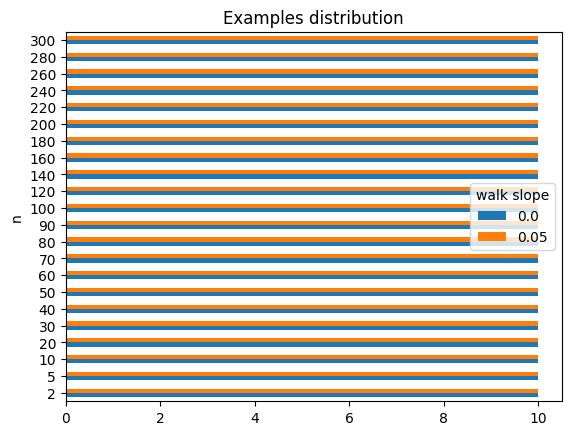

In [6]:
df[['n', 'walk slope']].value_counts().reset_index().pivot(columns='walk slope',index='n')['count'].plot(kind='barh')
plt.title('Examples distribution')
plt.show()

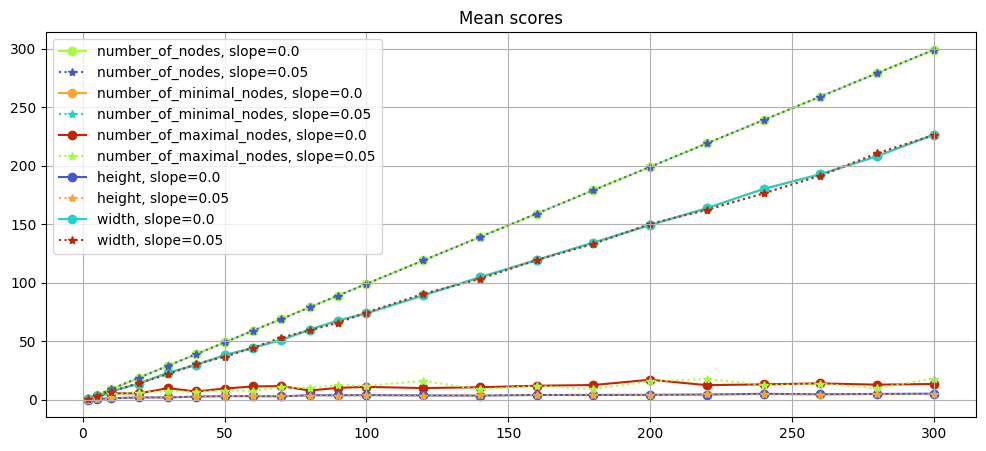

dfn.shape = (22, 10)


score      number_of_nodes       number_of_minimal_nodes        \
walk slope            0.00  0.05                    0.00  0.05   
n                                                                
2                      1.0   1.0                     1.0   1.0   
5                      4.0   4.0                     3.3   3.5   
10                     9.0   9.0                     7.2   7.0   
20                    19.0  19.0                    13.9  14.4   
30                    29.0  29.0                    23.0  21.9   

score      number_of_maximal_nodes      height      width        
walk slope                    0.00 0.05   0.00 0.05  0.00  0.05  
n                                                                
2                              1.0  1.0    0.0  0.0   1.0   1.0  
5                              2.8  3.5    0.7  0.5   3.3   3.5  
10                             5.5  4.7    1.3  1.2   7.2   7.0  
20                             5.5  6.2    2.0  2.0  13.9  14.4  
30                             9.9  7.5    2.0  2.3  23.0  21.9

In [74]:
dfn = df.groupby(['n', 'walk slope'])[[score.__name__ for score in scores]].mean()
dfn = dfn.reset_index()
dfn = dfn.pivot(index='n', columns='walk slope', values=[score.__name__ for score in scores])
dfn.columns.names = ('score', 'walk slope')

cmap = plt.get_cmap('turbo')

plt.figure(figsize=(12, 5))
plt.title('Mean scores')
for icol, col in enumerate(dfn.columns):
    linestyle = '-' if col[1] == 0 else ':'
    marker = 'o' if col[1] == 0 else '*'
    color = (0.5*(col[1] == 0) + 1.0*icol/len(dfn.columns))%1
    color = cmap(color)
    plt.plot(dfn.index, dfn[col], label=f'{col[0]}, slope={col[1]}',
            linestyle=linestyle, marker=marker, color=color, zorder=col[1] != 0)
plt.grid(True)
plt.legend()
plt.show()

print(f'dfn.shape = {dfn.shape}')
dfn.head()

In [39]:
import inspect

def get_init_args(obj):
    signature = inspect.signature(obj.__init__)
    bound = signature.bind_partial(obj)
    bound.apply_defaults()
    return {k: getattr(obj, k, None) for k in signature.parameters if k != 'self' }

df_lingress = pd.DataFrame({col: get_init_args(sp.stats.linregress(dfn.index, dfn[col])) for col in dfn.columns})
df_lingress.columns.names = ('score', 'walk slope')

df_lingress = df_lingress.transpose()[['slope', 'intercept', 'stderr']]
df_lingress

slope  intercept    stderr
score                   walk slope                               
number_of_nodes         0.00        1.000000  -1.000000  0.000000
                        0.05        1.000000  -1.000000  0.000000
number_of_minimal_nodes 0.00        0.748516  -0.345813  0.001951
                        0.05        0.746322  -0.339836  0.002858
number_of_maximal_nodes 0.00        0.031818   6.252766  0.005426
                        0.05        0.036141   5.844223  0.006748
height                  0.00        0.013043   1.774734  0.001579
                        0.05        0.012218   1.828997  0.001673
width                   0.00        0.748516  -0.345813  0.001951
                        0.05        0.746322  -0.339836  0.002858

# 2-dimensional Random Walk

19 19


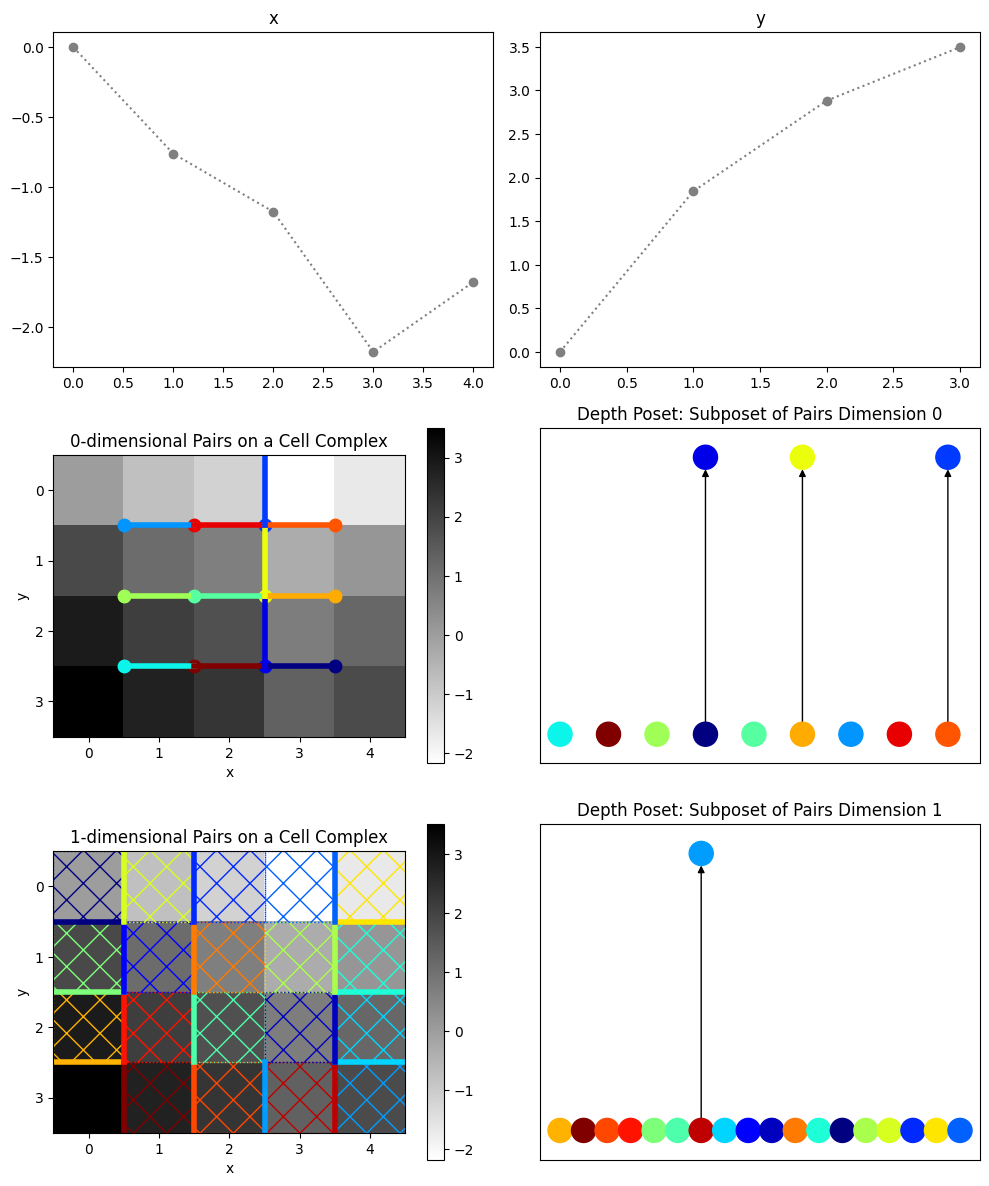

In [29]:
nsteps0 = 5
nsteps1 = 4

steps0 = np.random.normal(size=nsteps0)
steps1 = np.random.normal(size=nsteps1)
walk0 = np.cumsum(steps0)
walk1 = np.cumsum(steps1)
walk0 -= walk0[0]
walk1 -= walk1[0]
walk = walk0.reshape(1, -1) + walk1.reshape(-1, 1)

sources, matrix, dims, filter_values = get_ordered_border_matrix_from_matrix_of_heights(walk)
dp = DepthPoset.from_border_matrix(matrix.astype(int), dims=dims, filter_values=filter_values, sources=sources)


fig, axs = plt.subplots(3, 2, figsize=(10, 12), squeeze=False)
axs[0, 0].set_title(f'x')
axs[0, 0].plot(walk0, marker='o', color='grey', linestyle=':', zorder=0)
axs[0, 1].set_title(f'y')
axs[0, 1].plot(walk1, marker='o', color='grey', linestyle=':', zorder=0)

for i in [1, 2]:
    axs[i, 0].set_title(f'{i-1}-dimensional Pairs on a Cell Complex')
    axs[i, 1].set_title(f'Depth Poset: Subposet of Pairs Dimension {i-1}')
    im = axs[i, 0].imshow(walk, cmap='binary')
    cbar = fig.colorbar(im, ax=axs[i, 0])
    axs[i, 0].set_xticks(np.intersect1d(axs[i, 0].get_xticks(), np.arange(nsteps0)))
    axs[i, 0].set_yticks(np.intersect1d(axs[i, 0].get_yticks(), np.arange(nsteps1)))
    axs[i, 0].set_xlabel('x')
    axs[i, 0].set_ylabel('y')

dp0 = dp.subposet_dim(0)
node_colors0 = np.linspace(0, 1, len(dp0.nodes))
node_colors0 = np.random.choice(node_colors0, len(dp0.nodes), replace=False)
node_colors0 = plt.get_cmap('jet')(node_colors0)


def get_1dcell(c0, c1):
    # 
    center = np.mean([c0, c1], axis=0)
    if center[0] == int(center[0]):
        res = np.array([[-0.5, 0], [+0.5, 0]]) + center
    else:
        res = np.array([[0, -0.5], [0, +0.5]]) + center
    x, y = res.transpose()
    return x, y

for inode, node in enumerate(dp0.nodes):
    color = node_colors0[inode]
    simplex0, simplex1 = node.source
    y0, x0 = np.mean(simplex0, axis=0)
    axs[1, 0].scatter(x0, y0, color=color, linewidth=4)
    y1, x1 = get_1dcell(*simplex1)
    axs[1, 0].plot(x1, y1, color=color, linewidth=4)
    

nx.draw_networkx(dp0.get_transitive_reduction(), pos=dp0.hasse_layout(), node_color=node_colors0, ax=axs[1, 1], with_labels=False)


dp1 = dp.subposet_dim(1)
node_colors1 = np.linspace(0, 1, len(dp1.nodes))
node_colors1 = np.random.choice(node_colors1, len(dp1.nodes), replace=False)
node_colors1 = plt.get_cmap('jet')(node_colors1)

print(len(node_colors1), len(dp1.nodes))

for inode, node in enumerate(dp1.nodes):
    color = node_colors1[inode]
    simplex0, simplex1 = node.source
    y0, x0 = get_1dcell(*simplex0)
    axs[2, 0].plot(x0, y0, color=color, linewidth=4)
    
    axs[2, 0].fill_between(simplex1[0][1] + np.array([-0.5, 0.5]), 
                           simplex1[0][0] - 0.5*np.ones(2), 
                           simplex1[0][0] + 0.5*np.ones(2), 
                           facecolor='none', hatch='x', edgecolor=color, linestyle=':'
                           )

nx.draw_networkx(dp1.get_transitive_reduction(), pos=dp1.hasse_layout(), node_color=node_colors1, ax=axs[2, 1], with_labels=False)

plt.tight_layout()
plt.show()